# PCA on Face images

We shall apply the principal component analysis algorithm on black and white face images.  
We shall first use `sklearn`'s inbuilt PCA algorithm, then we shall implement the same from scratch using `numpy`

In [215]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import cv2

In [216]:
# INPUT PATHS:
BASE = '../input/att-database-of-faces/'

## Visualizing the data

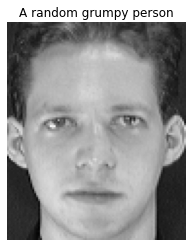

In [217]:
img = cv2.imread(BASE + 's1/1.pgm', 0) # '0' for reading grayscale images

IMG_SHAPE = img.shape

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('A random grumpy person')
plt.show()

## Creating the dataframe

In [218]:
filepaths = [] # Contains the absolute paths of all the image files
for s_i in os.listdir(BASE): # The folders containing the files are labelled as s1, s2, etc
    if s_i != 'README': # There is also a README file present in the data, this must be ignored
        for filename in os.listdir(BASE + s_i):
            filepaths.append(BASE + s_i + '/' + filename)

In [219]:
df = pd.DataFrame({'filepaths':filepaths})
display(df)

,filepaths
0,../input/att-database-of-faces/s21/6.pgm
1,../input/att-database-of-faces/s21/3.pgm
2,../input/att-database-of-faces/s21/2.pgm
3,../input/att-database-of-faces/s21/10.pgm
4,../input/att-database-of-faces/s21/8.pgm
...,...
395,../input/att-database-of-faces/s1/4.pgm
396,../input/att-database-of-faces/s1/7.pgm
397,../input/att-database-of-faces/s1/9.pgm
398,../input/att-database-of-faces/s1/5.pgm


Thus, now we have all the unlabelled data present as a dataframe.  
We shall now make an array consisting of these images present as a numpy array.  

*(Note that the above step is only implemented for better readability, we could have read the images in the previous loops itself.)*

In [220]:
images = []
for filepath in df['filepaths']:
    images.append(cv2.imread(filepath, 0).flatten())
images = np.array(images)

## Using the PCA provided in sklearn

In [221]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8) # Retain 80% of the variation
pca.fit(images)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

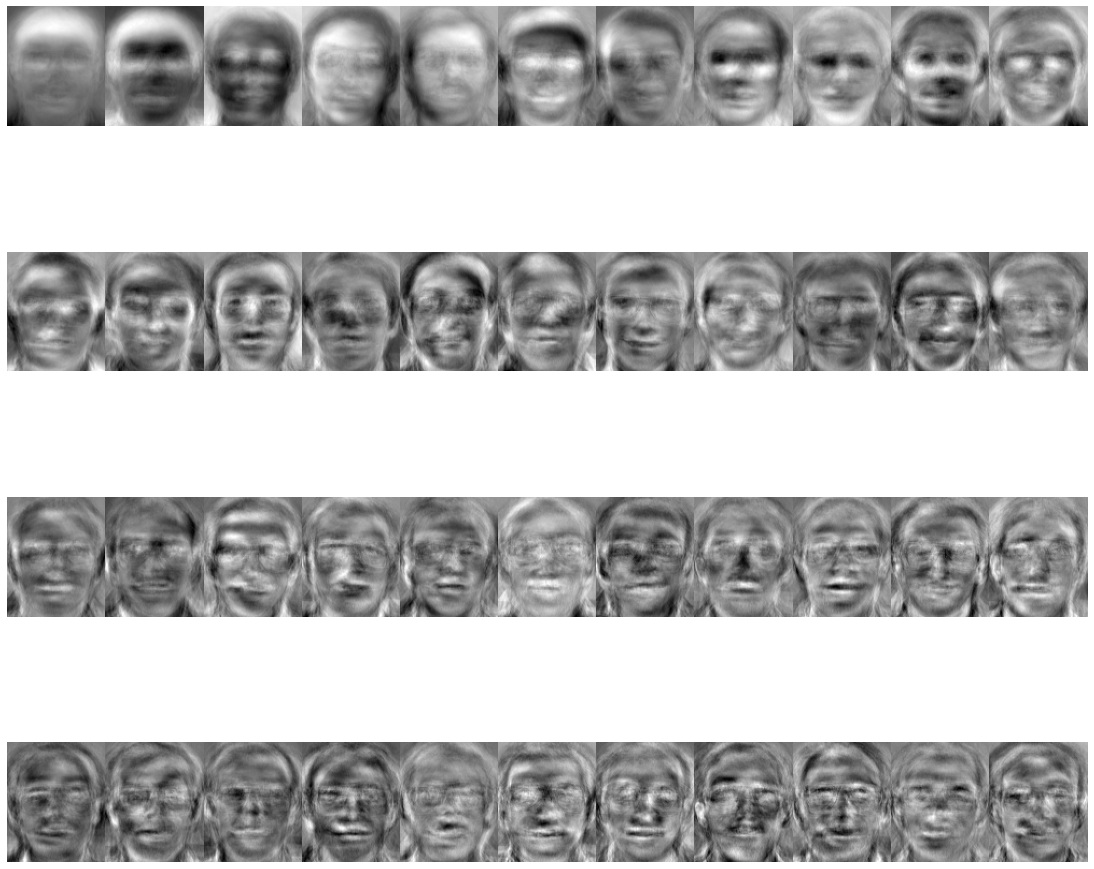

In [222]:
z = pca.components_

fig, axes = plt.subplots(4, 11, figsize = (15, 15))
for (ax,i) in zip(axes.flat, range(z.shape[0])):
    ax.imshow(z[i].reshape(IMG_SHAPE), cmap = 'gray')
    ax.axis('off')
fig.tight_layout(pad = 0)

Using the linear combination of these $44$ creepy images, we can approximately reconstruct *any* of the images present in the original datatset containing $400$ different images. 

These images form some sort of a '**basis**' (approximately) of the original 400 images, if consider that as a '**vector space**'  

Earlier, we required $112\times 92$ 'features' to represent each image, as there were that many pixels in each image.  
After applying PCA, we have just $44$ base images which contain the information (approximately) of all the $400$ images.  
Therefore, we have reduced the *dimensionality* of the unlabelled data from $10304$ to $44$.

## Approximate reconstruction of the original dataset

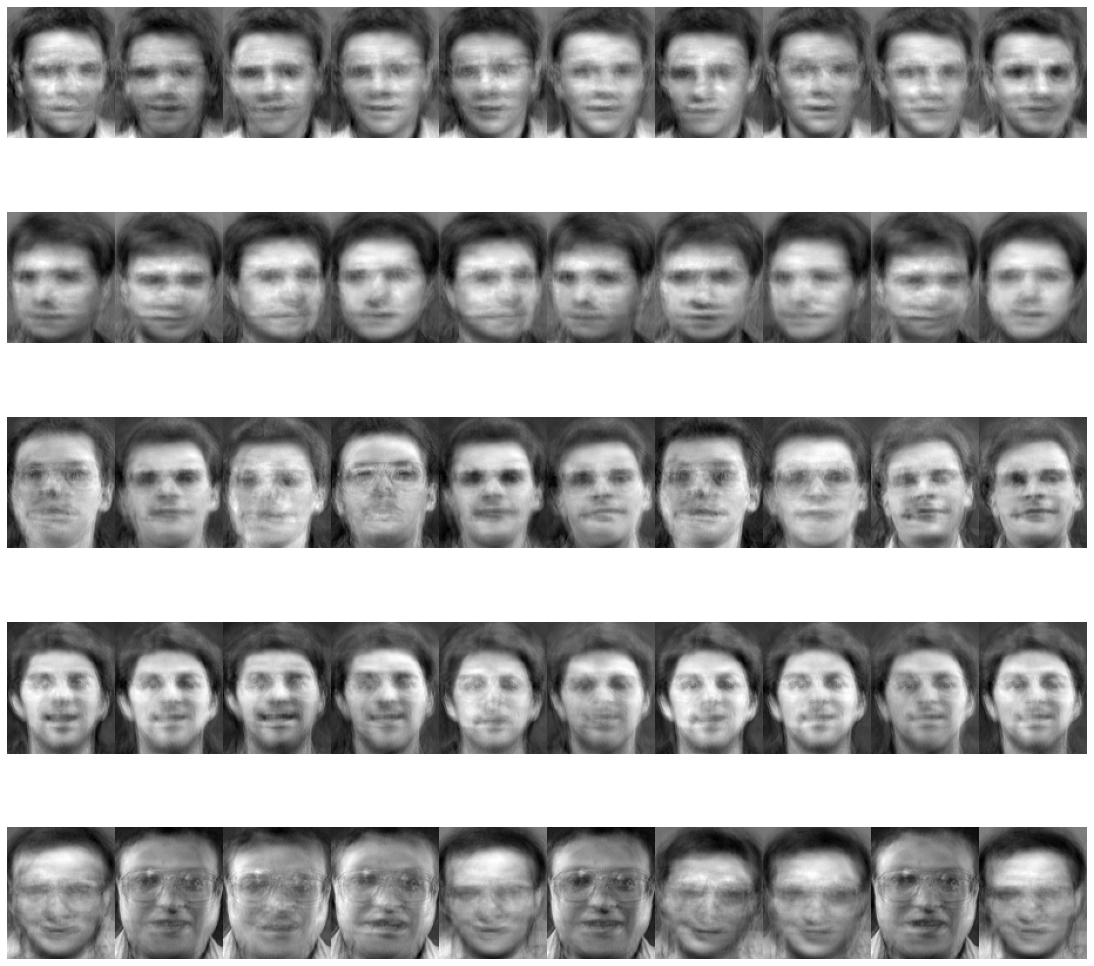

In [223]:
components = pca.transform(images) # A 400*44 matrix
projections = pca.inverse_transform(components) # A 400*10304 matrix
# First 50 reconstructed images:
fig, axes = plt.subplots(5, 10, figsize = (15, 15))
for (ax,i) in zip(axes.flat, range(projections.shape[0])):
    ax.imshow(projections[i].reshape(IMG_SHAPE), cmap = 'gray')
    ax.axis('off')
    if i >= 49:
        break
fig.tight_layout(pad = 0)

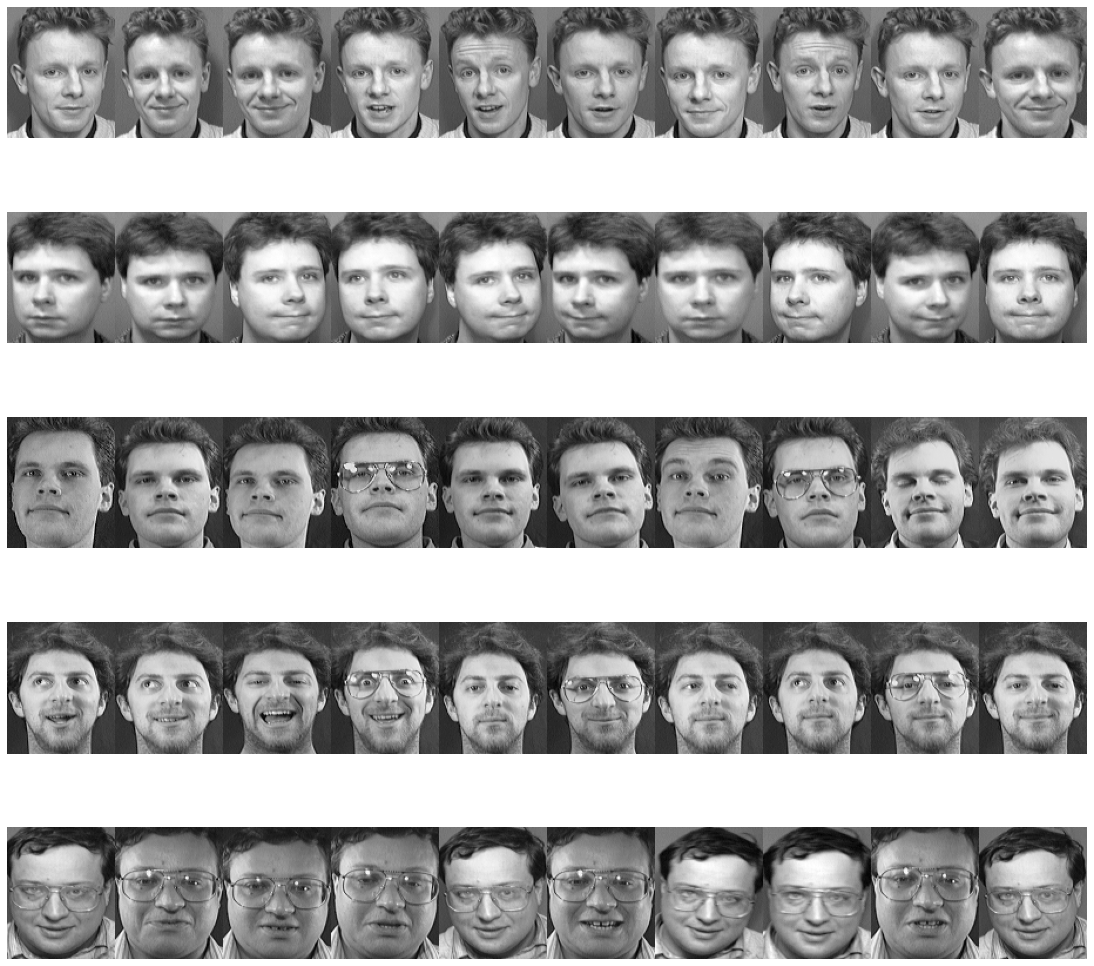

In [224]:
# First 50 actual images:
fig, axes = plt.subplots(5, 10, figsize = (15, 15))
for (ax,i) in zip(axes.flat, range(images.shape[0])):
    ax.imshow(images[i].reshape(IMG_SHAPE), cmap = 'gray')
    ax.axis('off')
    if i >= 49:
        break
fig.tight_layout(pad=0)

Pretty close? Let's see what actually goes on

$z$ is the $44$ dimensional vector which is the basis.  
This means that using a linear combination of these $44$ images, we can approximately reconstruct any of the original 400 images.  

Thus, for the $i^{th}$ image we have:  
$$A_i = a_{i,1}v_1 + a_{i,2}v_2 + \dots + a_{i,44}v_{44}$$

Where $A_i$ is the the $i^{th}$ image expressed as a linear combination of the $44$ vectors present in the basis. 

Thus taking $a_i = [\  a_{i,1} \dots a_{i,44} \ ]^T$ and $ z = [ v_1 \dots v_{44} ]^T $ we can write $A_i$ as:  
 
$$A_i = z^T\cdot a_i$$ 
  
Note that unlike the original $400$ images, these $44$ images are approximately *linearly independant* or, un-correlated, which is a better, less redundant representation of the data.

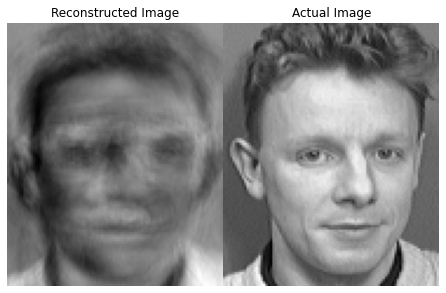

In [225]:
# Reconstructing the 0th image:

a_0 = components[0] # The components for the 0th image (that is, a_i1, a_i2,..., a_i44)
A_0 = np.dot(z.T, a_0)

# Displaying the images:
A_0 = A_0.reshape(IMG_SHAPE)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Reconstructed Image')
plt.imshow(A_0, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Actual Image')
plt.imshow(images[0].reshape(IMG_SHAPE), cmap='gray')
plt.tight_layout(pad = 0)
plt.show()

Now, after getting a basic intuition about PCA, we are hopefully ready to apply it from scratch.

# PCA from scratch

In [226]:
# We first calculate the means along each dimension of the unlabelled input data
featurewise_means = np.mean(images, axis=0) 

# Mean Normalization:
X = images - featurewise_means

In [227]:
# The reduced dimensionality
k = 44 # 80% of the variance is retained

# Computing the covariance matrix:
sigma = np.cov(X) # This is equal to ((X.T*X)/400)

# Computing the singular value decomposition of the covariance matrix:
U, S, V = np.linalg.svd(sigma)

# Choosing the first k columns of U
U_reduced = U[:, 0:k]

# Computing the k basis image vectors 
Z = np.dot(U_reduced.T, X)

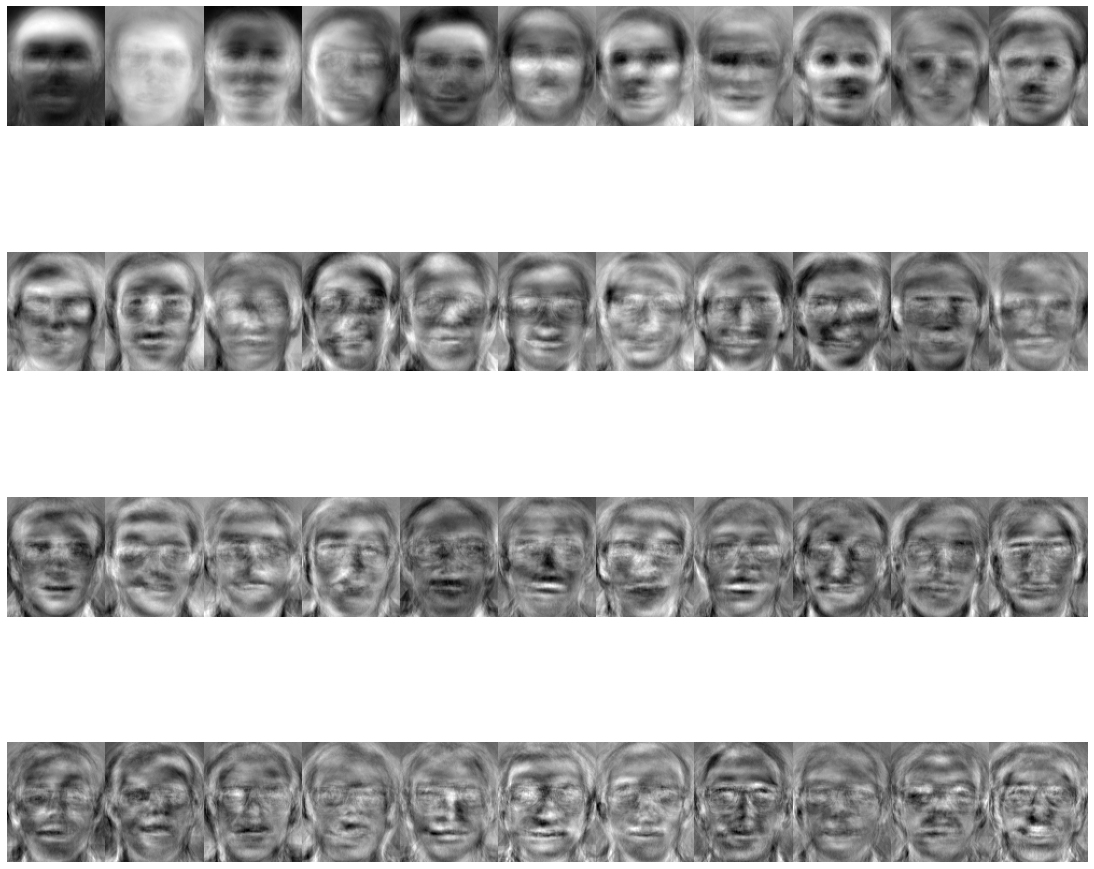

In [228]:
# Displaying the basis image vectors:

fig, axes = plt.subplots(4, 11, figsize = (15, 15))
for (ax,i) in zip(axes.flat, range(Z.shape[0])):
    ax.imshow(Z[i].reshape(IMG_SHAPE), cmap = 'gray')
    ax.axis('off')
fig.tight_layout(pad = 0)

Similar to the basis vectors obtained by running `sklearn`'s PCA. 

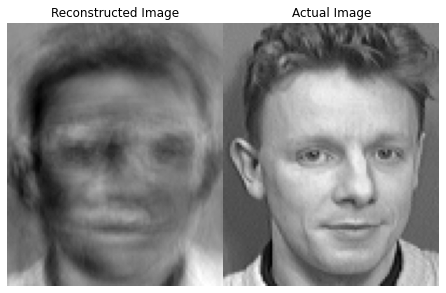

In [229]:
# Reconstructing the 0th image: 

# U_reduced is same as the 'components' matrix used previously
A_0 = np.dot(U_reduced[0], Z)

# Displaying the images:
A_0 = A_0.reshape(IMG_SHAPE)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Reconstructed Image')
plt.imshow(A_0, cmap='gray')
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Actual Image')
plt.imshow(images[0].reshape(IMG_SHAPE), cmap='gray')
plt.tight_layout(pad = 0)
plt.show()

This is same as the reconstruction obtained by `sklearn`'s PCA